In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

## 1. 데이터 로드

In [2]:
# 구글드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_transformer = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()
])
test_transformer = transforms.Compose([transforms.ToTensor()])

BATCH_SIZE = 4
NUM_WORKERS = 2

drive_path = '/content/drive/MyDrive/Colab Notebooks/딥러닝코딩/CIFAR10/'
train_dataset = CIFAR10(root=drive_path, train=True, download=True, transform=train_transformer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
print(train_dataset) # 5만개

test_dataset = CIFAR10(root=drive_path, train=False, download=True, transform=test_transformer)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
print(test_dataset) # 1만개

classes = train_dataset.classes # 10개
print(classes)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Colab Notebooks/딥러닝코딩/CIFAR10/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Colab Notebooks/딥러닝코딩/CIFAR10/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


train img shape:torch.Size([4, 3, 32, 32])
train img shape:torch.Size([3, 32, 32])


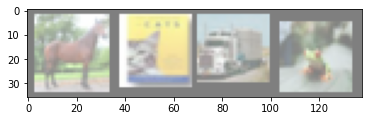

horse cat   truck frog 


In [4]:
# 이미지를 보여주는 함수
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(f'train img shape:{images.shape}')
print(f'train img shape:{images[0].shape}')

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답 레이블 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

## 2. 모델 정의

In [5]:
# ResNet 안의 반복되는 conv layer 2개
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터 사용
        # stride=2로 하면 너비, 높이를 반으로 줄어듦
        # BatchNorm에 bias가 포함되어 있으므로 Conv2d에서 bias=False
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch) # 배치 정규화(batch normalization)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential() # identity mapping인 경우
        if stride != 1: # 입출력 차원이 다른 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # skip connection
        out = self.relu(out)
        return out

In [7]:
# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_ch = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # 입력 이미지 절반으로 줄임
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512, num_classes)
        self.avg_pool = nn.AvgPool2d(kernel_size=4)

    def _make_layer(self, block, out_ch, num_blocks, stride):
        # 첫 번째 layer stride는 그대로, 나머지 layer stride는 1로
        # 첫 번째 conv layer에서만 입력 이미지가 절반으로 줄어들기 때문
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        # block은 BasicBlock의 객체를 의미함
        for stride in strides:
            layers.append(block(self.in_ch, out_ch, stride))
            self.in_ch = out_ch # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out) # 출력: [batch_size, 512, 4, 4]
        # out = F.avg_pool2d(out, 4) # 출력: [batch_size, 512, 1, 1]
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1) # 출력: [batch_size, 512]
        out = self.fc(out)
        return out


# ResNet18 함수 정의
def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [8]:
# GPU상에서 테스트
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

input_img = torch.randn(size=(1, 3, 32, 32), dtype=torch.float).to(device)
print(f'input img shape: {input_img.shape}')

model = resnet18().to(device)
print(summary(model, (3, 32, 32)))

device: cuda
input img shape: torch.Size([1, 3, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32

## 3. 손실 함수와 optimizer 정의하기

In [9]:
net = resnet18()
net = net.to(device)

NUM_EPOCHS = 20

LEARNING_RATE = 1e-2
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

## 4. 신경망 학습하기

In [11]:
loss_list = []
acc_list = []

def train(epoch, loss_list, acc_list):
    print('\n [Train epoch: %d]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) # (이미지, 정답 라벨)

        # gradient 매개변수를 0으로 만들고
        optimizer.zero_grad()

        outputs = net(inputs) # 순전파
        loss = criterion(outputs, targets) # (모델 예측값, 정답)
        loss.backward() # 역전파
        optimizer.step() # 최적화

        # loss 출력
        train_loss += loss.item()
        _, preds = outputs.max(1)
        total += targets.size(0)
        cur_correct = (preds == targets).sum().item() 
        correct += cur_correct

        if batch_idx % 1000 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current batch average train accuracy:', cur_correct / targets.size(0))
            print('Current batch average train loss:', loss.item() / targets.size(0))
    
    # 시각화 용도
    loss_list.append(loss.cpu().detach().numpy())
    acc_list.append(cur_correct / targets.size(0))

    print('\nTotal average train accuarcy:', correct / total)
    print('Total average train loss:', train_loss / total)

In [12]:
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/딥러닝코딩/resnet18_ep20.pth'

def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    val_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device) # (이미지, 정답 라벨)

        outputs = net(inputs) # 모델 예측값
        loss = criterion(outputs, targets) # (모델 예측값, 정답)

        # loss 출력
        val_loss += loss.item()
        _, preds = outputs.max(1)
        total += targets.size(0)
        cur_correct = (preds == targets).sum().item() 
        correct += cur_correct

    print('\nTotal average test accuarcy:', correct / total)
    print('Total average test loss:', loss / total)

    state = {
        'resnet18': net.state_dict()
    }
    # if not os.path.isdir('checkpoint'):
    #     os.mkdir('checkpoint')
    # torch.save(state, './checkpoint/' + file_name)
    torch.save(state, SAVE_PATH)
    print('Model Saved!')

In [14]:
import time

def adjust_lr(optimizer, epoch):
    lr = LEARNING_RATE
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

start_time = time.time()

NUM_EPOCHS = 20
for epoch in range(0, NUM_EPOCHS):
    adjust_lr(optimizer, epoch)
    train(epoch, loss_list, acc_list)
    test(epoch)
    print('\nTime elapsed:', time.time() - start_time)


 [Train epoch: 0]

Current batch: 0
Current batch average train accuracy: 0.25
Current batch average train loss: 0.4002344012260437

Current batch: 1000
Current batch average train accuracy: 0.75
Current batch average train loss: 0.2243955284357071

Current batch: 2000
Current batch average train accuracy: 0.5
Current batch average train loss: 0.5441015958786011

Current batch: 3000
Current batch average train accuracy: 1.0
Current batch average train loss: 0.09319271147251129

Current batch: 4000
Current batch average train accuracy: 0.75
Current batch average train loss: 0.09715964645147324

Current batch: 5000
Current batch average train accuracy: 0.25
Current batch average train loss: 0.5085937976837158

Current batch: 6000
Current batch average train accuracy: 0.0
Current batch average train loss: 0.4978185296058655

Current batch: 7000
Current batch average train accuracy: 0.75
Current batch average train loss: 0.18535073101520538

Current batch: 8000
Current batch average train

## 5. 테스트하기

In [25]:
epochs = np.arange(0, NUM_EPOCHS)
len(epochs)

print(loss_list)
print(acc_list)

[array(1.6151443, dtype=float32), array(1.0074197, dtype=float32), array(0.5117777, dtype=float32), array(0.92442924, dtype=float32), array(0.78147465, dtype=float32), array(0.9067563, dtype=float32), array(0.30906492, dtype=float32), array(0.98513985, dtype=float32), array(0.4357605, dtype=float32), array(0.5467816, dtype=float32), array(0.5729968, dtype=float32), array(0.10654321, dtype=float32), array(1.0631537, dtype=float32), array(0.06176629, dtype=float32), array(0.67173105, dtype=float32), array(0.3344156, dtype=float32), array(0.11142839, dtype=float32), array(0.133595, dtype=float32), array(1.0414276, dtype=float32), array(0.40883386, dtype=float32), array(0.20912601, dtype=float32), array(1.302084, dtype=float32)]
[0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 1.0, 0.75, 0.75, 0.75, 0.75, 1.0, 0.5, 1.0, 0.75, 1.0, 1.0, 1.0, 0.25, 0.75, 1.0, 0.5]


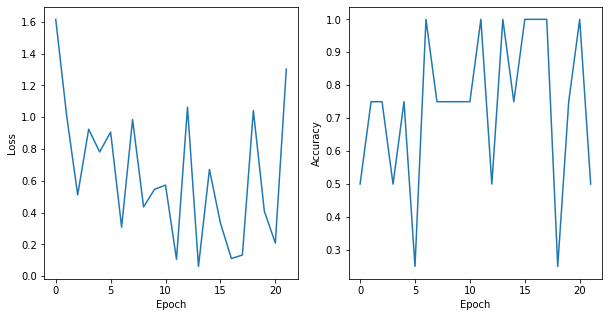

In [21]:
## loss, acc 그래프
epochs = np.arange(0, NUM_EPOCHS+2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, loss_list)

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, acc_list)
plt.show()

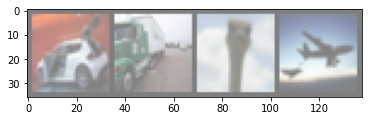

GroundTruth:  automobile truck bird  airplane


In [22]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

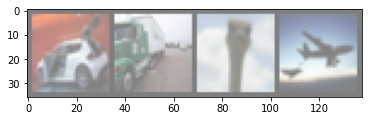

Predicted:  automobile truck bird  airplane


In [23]:
##  저장한 모델 로드해 테스트

net = resnet18().to(device)
net.load_state_dict(torch.load(SAVE_PATH)['resnet18'])

# 출력은 10개 분류 각가에 대한 값
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1) # 값이 가장 높은 클래스 하나 뽑기

imshow(torchvision.utils.make_grid(images.cpu()))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [24]:
correct = 0
total = 0

# 학습 중이 아니므로 gradient를 계산할 필요가 없음
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images) # 신경망에 이미지를 통과시켜 출력 계산
        _, preds = torch.max(outputs.data, 1) # 가장 큰 값을 가지는 클래스 뽑기
        total += labels.size(0) # 전체 테스트 데이터 개수
        correct += (preds == labels).sum().item() # 맞춘 데이터 개수

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


In [26]:
## 각 클래스별 예측값 계산

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, preds = torch.max(outputs.data, 1)
        for label, pred in zip(labels, preds):
            if label == pred:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 74.9 %
Accuracy for class: automobile is 77.8 %
Accuracy for class: bird  is 58.3 %
Accuracy for class: cat   is 54.4 %
Accuracy for class: deer  is 75.2 %
Accuracy for class: dog   is 80.4 %
Accuracy for class: frog  is 70.3 %
Accuracy for class: horse is 47.7 %
Accuracy for class: ship  is 78.5 %
Accuracy for class: truck is 93.4 %
